# Lập trình bootstrap với Python
# Bài 4: Kỹ thuật Bootstrap kép 

**BS. Lê Ngọc Khả Nhi**

# Dẫn nhập

Đây là bài thứ 4 của loạt bài về chuyên đề lập trình Bootstrap với ngôn ngữ Python. Trong bài này, Nhi sẽ giới thiệu với các bạn một kỹ thuật khác để ước tính khoảng tin cậy, đó là quy trình bootstrap kép. Ngoài ra, chúng ta sẽ làm một thí nghiệm có độ phức tạp cao hơn khi áp dụng bootstrap cho ma trận array 2 chiều. Như những lần trước, Nhi sẽ trình bày song song 2 giải pháp, chạy trên CPU (numpy) và GPU (Pytorch).

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import torch
from random import choices

import seaborn as sns
import matplotlib.pyplot as plt

# Bài toán minh họa

Nhi tiếp tục sử dụng bộ dữ liệu chức năng hô hấp trên 133 bệnh nhân bệnh phổi mô kẽ (ILD). Lần này mục tiêu đặt ra là khảo sát tương quan giữa 5 chỉ số chức năng hô hấp, bao gồm DLCO, VA, TLC, FVC và FEV1

Ta tạo ra 1 numpy array chứa dữ liệu này như bên dưới:

In [8]:
# Tải dữ liệu 

path = 'https://raw.githubusercontent.com/kinokoberuji/Statistics-Python-Tutorials/master/Schleroderma.csv'
df = pd.read_csv(path, sep = ';', decimal = ',')

sample = df[df['ILD'] == 'Positive'][['DLCO','VA','TLC','FEV1','FVC']]

sample

,DLCO,VA,TLC,FEV1,FVC
50,11.73,3.98,3.34,1.71,2.13
52,16.75,5.23,4.88,1.91,2.57
53,10.59,2.74,3.19,1.39,1.60
57,8.64,2.80,3.32,1.69,1.72
58,20.15,5.88,5.43,2.48,3.13
...,...,...,...,...,...
374,17.28,3.62,4.95,3.04,3.60
375,7.77,3.03,3.06,1.32,1.64
380,10.09,2.93,3.33,1.93,2.19
386,11.81,2.92,3.53,1.73,1.97


# Quy trình Bootstrap kép

Trong bài này, trị số thống kê ta cần ước lượng là hệ số tương quan r theo Pearson, tuy nhiên Nhi sẽ không chỉ muốn dùng Bootstrap ước tính r cho từng cặp biến (2 arrays 1 chiều), nhưng sẽ áp dụng Bootstrap để ước lượng khoảng tin cậy 95% (BCI95%) cho toàn bộ ma trận tương quan 5 x 5 biến.

Ta sẽ làm việc này bằng một ký thuật thú vị là Bootstrap kép. Nội dung của quy trình bootstrap kép trên một array dữ liệu có thể tóm tắt ngắn gọn như sau:

0) Dữ liệu đầu vào là 1 array X (trong thí dụ này, X có 2 chiều: (k,n)); áp dụng hàm thống kê fs() trên X, ta tính được trị số thống kê mục tiêu là theta_hat


+ Sử dụng 1 nested loop gồm 2 vòng lặp lồng vào nhau: 

1) Trong vòng lặp thứ nhất, ta chọn mẫu ngẫu nhiên có hoàn lại để tạo ra một mẫu gọi là bootsample; áp dụng một hàm thống kê fs() để ước tính trị số thống kê mục tiêu (theta_hat_star, ở đây là ma trận tương quan (k,k)) và lặp lại m1 lượt, mỗi lượt như vậy sẽ lưu kết quả vào một tập hợp theta_hat_stars (ở đây là 1 array 3 chiều: (m1, k, k).

2) Tại mỗi lượt bootstrap trong vòng lặp thứ nhất, ta thực hiện vòng bootstrap thứ cấp, gồm m2 lượt tái chọn mẫu. Đầu tiên ta chuẩn bị 1 tập hợp tên là innervalues (trong thí dụ này là 1 array 3 chiều (m2, k, k)); Ta tái chọn mẫu có hoàn lại trên mẫu bootsample hiện thời, để tạo ra mẫu bootstrap thứ cấp là innersample; Ta cũng dùng hàm thống kê fs() để tính trị số thống kê mục tiêu và sao lưu vào tập hợp innervalues.

3) Trở lại vòng lặp thứ nhất, sau khi m2 lượt bootstrap đã xong, ta ước tính được sai số chuẩn SE_theta_hat_star trên innervalues; từ đó tính được trị số t = (theta_hat_star - theta_hat) / SE_theta_hat_star; sao lưu giá trị t này vào tập hợp tvalues (ở đây là một array 3 chiều (m1,k,k));

4) Sau khi m1 x m2 lượt bootstrap kết thúc, ta ước tính được sai số chuẩn SE_theta_hat của tập hợp giá trị theta_hat_stars;
Tiếp theo, ta tính phân vị 2.5 (LL) và 97.5 (UL) của tập hợp tvalues; Sau cùng, ta ước tính ngưỡng trên và dưới khoảng tin cậy 95% từ theta_hat, LL,UL và SE_theta_hat


# Giải pháp sử dụng numpy (CPU)

Tạo numpy array XY từ dữ liệu 5 biến x 133 cá thể, XY là 1 ma trận (array) shape = (5,133)

In [39]:
XY = sample.values.T

XY.shape

(5, 133)

In [40]:
# Đây là theta_hat: ma trận tương quan 5x5
    
theta_hat = np.corrcoef(XY)

theta_hat

array([[1.        , 0.61557568, 0.53451659, 0.55436493, 0.56167457],
       [0.61557568, 1.        , 0.7228848 , 0.63380322, 0.69532735],
       [0.53451659, 0.7228848 , 1.        , 0.74469447, 0.82582831],
       [0.55436493, 0.63380322, 0.74469447, 1.        , 0.93188789],
       [0.56167457, 0.69532735, 0.82582831, 0.93188789, 1.        ]])

In [41]:
reps1 = 2000 # Vòng bootstrap bên ngoài 2000 lượt
reps2 = 1000 # Vòng bên trong 1000 lượt

Tiến hành quy trình bootstrap kép 1000 x 2000 lượt

In [42]:
# Số hàng trong ma trận đầu vào
k = XY.shape[1]

# Tập hợp kết quả vòng lặp bên ngoài
tvalues = np.zeros((reps1, XY.shape[0], XY.shape[0]))
theta_hat_stars = np.zeros((reps1, XY.shape[0], XY.shape[0]))

# Vòng lặp ngoài
for r1 in range(reps1):
    idx = np.random.choice(np.arange(0,k),k, replace = True)
    bootsample = XY[:,idx]
    
    theta_hat_star = np.corrcoef(bootsample)
    theta_hat_stars[r1] = theta_hat_star
    
    innervalues = np.zeros((reps2, XY.shape[0], XY.shape[0]))
    
    # Vòng lặp trong
    for r2 in range(reps2):
        idx = np.random.choice(np.arange(0,k),k, replace = True)
        innersample = bootsample[:,idx]
        innervalues[r2] = np.corrcoef(innersample)
    
    SE_theta_hat_star = np.nanstd(innervalues, axis = 0)
    t = (theta_hat_star - theta_hat) / SE_theta_hat_star
    tvalues[r1] = t

# Ước tính 95%BCI 
SE_theta_hat = np.nanstd(theta_hat_stars, axis = 0)
lower = np.quantile(tvalues, 0.025, axis = 0)
upper = np.quantile(tvalues, 0.975, axis = 0)
CI_lower = theta_hat - SE_theta_hat * upper
CI_upper = theta_hat - SE_theta_hat * lower

Đây là ngưỡng dưới

In [43]:
CI_lower

array([[1.        , 0.45446968, 0.35966568, 0.43091773, 0.42286074],
       [0.45446968, 1.        , 0.50472491, 0.50760258, 0.52130645],
       [0.35966568, 0.50472491, 1.        , 0.64041721, 0.75131658],
       [0.43091773, 0.50760258, 0.64041721, 1.        , 0.90466722],
       [0.42286074, 0.52130645, 0.75131658, 0.90466722, 1.        ]])

Đây là nguỡng trên...

In [44]:
CI_upper

array([[1.        , 0.78540205, 0.70321157, 0.6476862 , 0.66324844],
       [0.78540205, 1.        , 0.85876149, 0.73695316, 0.7916485 ],
       [0.70321157, 0.85876149, 1.        , 0.81780564, 0.87908088],
       [0.6476862 , 0.73695316, 0.81780564, 1.        , 0.95432677],
       [0.66324844, 0.7916485 , 0.87908088, 0.95432677, 1.        ]])

Kết quả trên có thể được trình bày thành biểu đồ như sau:

In [36]:
def CI_corrmat(M_corr,L_corr,U_corr):
    
    mask = np.triu(np.ones_like(M_corr, dtype=bool))

    f, axes = plt.subplots(nrows=1, ncols=3,figsize=(10,3))

    axes[1].set_title('Ước tính')
    axes[0].set_title('Ngưỡng dưới KTC')
    axes[2].set_title('Ngưỡng trên KTC')

    for i, cmat in enumerate([L_corr,M_corr,U_corr]):

        sns.heatmap(cmat,
                        mask=mask, 
                        vmax= 1.0,
                        vmin = -1.0,
                        center=0,
                        cmap = plt.cm.coolwarm,
                        square=True, 
                        linewidths=.5, 
                        cbar = False,
                       annot=True, fmt=".3f",
                       ax = axes[i])

    plt.show()

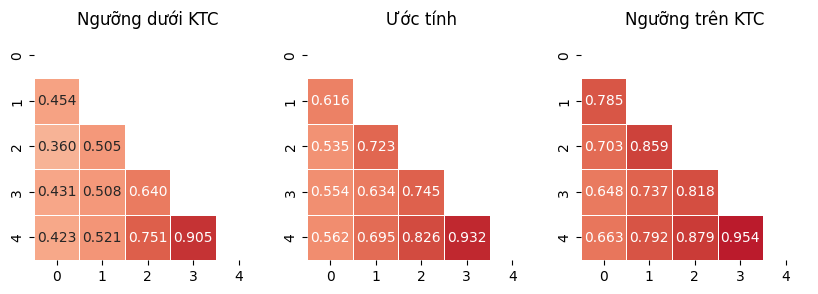

In [45]:
CI_corrmat(theta_hat ,CI_lower ,CI_upper)

Ta kiểm tra bằng cách đối chiếu với method corr của pandas:

In [29]:
sample.corr(method = 'pearson')

,DLCO,VA,TLC,FEV1,FVC
DLCO,1.000000,0.615576,0.534517,0.554365,0.561675
VA,0.615576,1.000000,0.722885,0.633803,0.695327
TLC,0.534517,0.722885,1.000000,0.744694,0.825828
FEV1,0.554365,0.633803,0.744694,1.000000,0.931888
FVC,0.561675,0.695327,0.825828,0.931888,1.000000


# Giải pháp sử dụng GPU (Pytorch)

Phần tiếp theo trình bày cùng quy trình trên, nhưng thi hành trên GPU sử dụng thư viện Pytorch. 

Quy trình này cần 2 hàm rời, một là torch_boot_idx để sinh mẫu ngẫu nhiên có hoàn lại; hai là một hàm corrcoef mô phỏng tính năng của hàm corrcoef của thư viện numpy, nhưng cho torch.tensor và cho phép chạy trên GPU.

In [30]:
def torch_boot_idx(pop_size, num_samples):
    p = torch.ones(pop_size, device='cuda') / pop_size
    return p.multinomial(num_samples=num_samples, replacement=True)

In [31]:
def corrcoef(x):

    # Ma trận hiệp phương sai:
    mean_x = torch.mean(x, 1)
    xm = (x.unsqueeze(0) - mean_x.unsqueeze(1)).reshape(x.size())
    c = xm.mm(xm.t())
    c = c / (x.size(1) - 1)

    # Chuẩn hòa ma trận hiệp phương sai
    d = torch.diag(c)
    stddev = torch.pow(d, 0.5)
    c = c.div(stddev.expand_as(c))
    c = c.div(stddev.expand_as(c).t())
    
    # Chặn 2 đầu -1,1
    c = torch.clamp(c, -1.0, 1.0)

    return c

Dữ liệu đầu vào là 1 tensor 2 chiều tor_X được chuyển từ numpy array ở trên:

In [46]:
tor_X = torch.tensor(XY, device = 'cuda', dtype=torch.float32)

k = tor_X.shape[1]

k

133

Đây là quy trình bootstrap kép trên GPU:

In [47]:
reps1 = 2000
reps2 = 1000

tvalues = torch.zeros(size = (reps1, XY.shape[0], XY.shape[0],),
                         device = 'cuda', 
                         dtype = torch.float32)

theta_hat_stars = torch.zeros(size = (reps1, XY.shape[0], XY.shape[0],),
                         device = 'cuda', 
                         dtype = torch.float32)

theta_hat = corrcoef(tor_X)

for r1 in range(reps1):
    
    tor_idx = torch_boot_idx(pop_size = k, num_samples = k)
    
    bootsample = tor_X[:,tor_idx]
    
    theta_hat_star = corrcoef(bootsample)
    theta_hat_stars[r1] = theta_hat_star
    
    innervalues = torch.zeros(size = (reps2, XY.shape[0], XY.shape[0],),
                              device = 'cuda', 
                              dtype = torch.float32)
    
    for r2 in range(reps2):
        tor_idx = torch_boot_idx(pop_size = k, num_samples = k)
        
        innersample = bootsample[:,tor_idx]
        innervalues[r2] = corrcoef(innersample)
    
    SE_theta_hat_star = torch.std(innervalues, axis = 0)
    t = (theta_hat_star - theta_hat) / SE_theta_hat_star
    tvalues[r1] = t
    
SE_theta_hat = torch.std(theta_hat_stars, axis = 0)
lower = torch.quantile(tvalues, 0.025, axis = 0)
upper = torch.quantile(tvalues, 0.975, axis = 0)
CI_lower = theta_hat - SE_theta_hat * upper
CI_upper = theta_hat - SE_theta_hat * lower

Ta nhận thấy kết quả tương tự như trên:

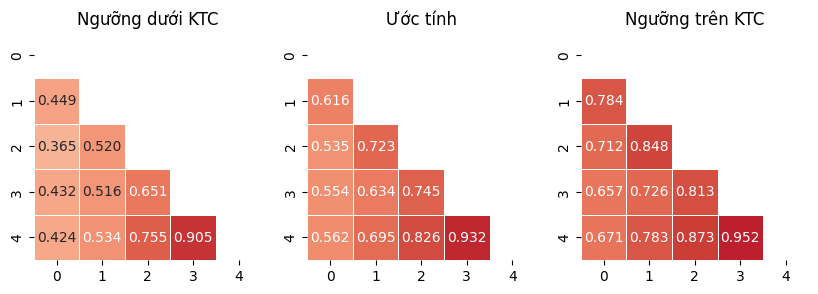

In [48]:
CI_corrmat(theta_hat.cpu().numpy(),
          CI_lower.cpu().numpy(),
           CI_upper.cpu().numpy()
          )

Qua bài thực hành này, các bạn biết thêm một kỹ thuật khác là bootstrap kép để ước tính khoảng tin cậy. Ngoài ra, ta có thể nhận ra rằng sau công đoạn tái chọn mẫu, ta có thể làm bất cứ quy trình phức tạp nào trên các mẫu ngẫu nhiên này, chứ không chỉ đơn giản là ước tính vài trị số thống kê. Trong thí dụ này, ước lượng thống kê có bản chất là tính toán trên ma trận 2 chiều và sử dụng toàn array và tensor để làm placeholder chứa kết quả là những con số , tuy nhiên ta cũng có thể ước tính hàng loạt trị số thống kê khác nhau và sử dụng những cấu trúc dữ liệu khác như pandas dataframe hay python dictionary.

Chúc các bạn thực hành vui.